<script type="text/x-mathjax-config">

MathJax.Hub.Config({

  tex2jax: {inlineMath: [['$','$'], ['\\(','\\)']]}

});

</script>

<script src='https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.5/latest.js?config=TeX-MML-AM_CHTML' async></script>

## Project3 다중 분류기

### 1. 개요

이번 프로젝트에서는 앞서 구현한 이진 분류기 모델을 다중 분류기로 확장하는 OvR 방식의 새로운 모델을 구현하고자 한다.

이진 분류기 모델은 projectfiles.binclassifier.py에 정의되어있는 세가지 모델들 중 하나를 이용한다.

또한 데이터의 분석과 시각화를 위해서 미리 정의해둔 플로팅 함수들을 사용한다. 해당 함수들은 projectfiles.analyzer.graphics에 정의되어있다.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from projectfiles.analyzer.graphics import plot_decision_regions, plot_data
from projectfiles.binclassifier import AdalineGD, AdalineSGD, LogisticRegression

### 2. 다중 클래스 분류기

앞선 프로젝트에서 구현한 이진 분류기 모델은 서로 다른 두 클래스 레이블을 구분하는 결정 경계를 정의할 수 있다. 이런 이진 분류기들은
클래스 레이블이 2개 일 때는 효과적으로 작동하지만 클래스 레이블이 3개 이상인 경우 제대로 작동하지 않는다. 따라서 클래스 레이블이 3개
이상인 경우 새로운 방식의 분류기 모델이 필요하다.

다중 클래스 분류기를 만드는 방법에는 여러가지가 있다. 이번에는 OvR(One versus Rest) 방식을 이용하여 기존에 구현한 이진 분류기 모델을 다중 클래스 분류기로 확장하고자 한다. 이에 앞서 먼저 다중 클래스 분류기에 대해 설명하고자 한다.

다중 클래스 분류기는 3개 이상의 클래스 레이블을 구분하지만 본질적으로 이진 분류기와 그 동작이 비슷하다. 앞서 구현한 이진 분류기 모델들은 두 클래스 레이블을 구분하는 직선을 하나 그리는 방식으로 작동하였는데, 이는 다중 분류기 모델 또한 동일하다. 예를 들어 다음과 같이 표현되는 데이터셋이 있다고 가정하자. 아래 데이터셋은 앞선 프로젝트에서 사용헸던 붓꽃 데이터셋이다. 다만 이번에는 2개의 클래스 레이블 뿐만 아니라 모든 클레스 레이블을 다 사용한다.

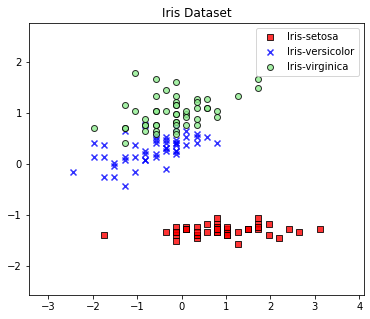

In [2]:
# 붓꽃 데이터셋
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)

# distracting class labels
y = df.iloc[0:150, 4].values
ynames = {}

for idx, lbl in enumerate(np.unique(y)):
    y[np.where(y == lbl)] = idx
    ynames[idx] = lbl

# distracting data features
X = df.iloc[0:150, [1, 2]].values
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

# plotting data
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot()

plot_data(X_std, y, resolution=0.02, names=ynames, ax=ax)
ax.set_title("Iris Dataset")
ax.legend(loc="upper right")

plt.show()

이러한 형태의 데이터를 분류하기 위해서는 2개 이상의 결정 경계가 필요하다. 이 데이터의 경우 완벽하게 구분하기 위해 총 2개의 직선이 필요하다. 앞선 프로젝트에서 하나의 이진 분류기가 하나의 직선을 생성했으므로 이 경우 최소 2개의 이진 분류기가 필요하다.

직관적으로는 이렇게 이해할 수 있지만 실제로 다중 분류기를 구현하기 위해서는 2개보다 더 많은 이진 분류기가 필요하다. 완전한 형태의 다중 분류기를 구현하기에 앞서 먼저 3개의 이진 분류기로 다중 분류기를 구현하고자 한다. 각 이진 분류기의 역할은 다음과 같다:

* model0: 0번 클래스 레이블만을 양성으로 분류한다.
* model1: 1번 클래스 레이블만을 양성으로 분류한다.
* model2: 2번 클래스 레이블만을 양성으로 분류한다.

이 세가지의 모델들을 이용하여 다중 분류기를 만들고자 한다. 만약 어떤 데이터 샘플이 model0에 대해 양성 클래스로 분류가되고, 나머지 모델들에 대해 음성 클래스로 분류된다고 가정하자. 그럼 해당 데이터 샘플은 0번 클래스 레이블이라고 추측할 수 있다. (혹은 그렇게 추측하는 것이 제일 타당하다) 이런 방식으로 데이터 샘플을 분류하는 다중 분류기를 구현하고자 한다.

아래 코드는 각 이진 분류기 모델을 학습하는 코드이다.

In [3]:
# 각 이진 분류기 모델의 생성
model0 = LogisticRegression(eta=0.01, n_iter=1000, random_state=1)
model1 = LogisticRegression(eta=0.01, n_iter=1000, random_state=1)
model2 = LogisticRegression(eta=0.01, n_iter=1000, random_state=1)

# 각 모델을 학습하는데 사용되는 데이터 레이블
y0 = np.zeros(y.shape)
y1 = np.zeros(y.shape)
y2 = np.zeros(y.shape)

y0[np.where(y == 0)] = 1
y1[np.where(y == 1)] = 1
y2[np.where(y == 2)] = 1

# fitting each binary classifiers
model0.fit(X_std, y0, shuffle=True)
model1.fit(X_std, y1, shuffle=True)
model2.fit(X_std, y2, shuffle=True)

그리고 아래 코드를 이용하여 각 모델의 결정 경계를 확인한다.

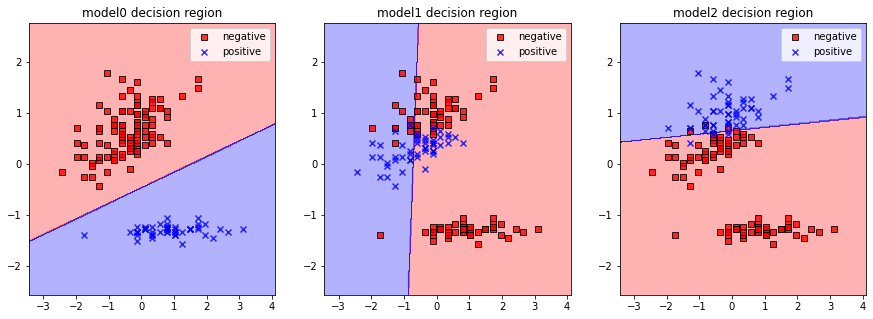

In [4]:
fig = plt.figure(figsize=(15, 5))
ax0 = fig.add_subplot(1, 3, 1)
ax1 = fig.add_subplot(1, 3, 2)
ax2 = fig.add_subplot(1, 3, 3)

plot_decision_regions(X_std, y0, model0, resolution=0.02, names={1:"positive", 0:"negative"}, ax=ax0)
plot_decision_regions(X_std, y1, model1, resolution=0.02, names={1:"positive", 0:"negative"}, ax=ax1)
plot_decision_regions(X_std, y2, model2, resolution=0.02, names={1:"positive", 0:"negative"}, ax=ax2)

ax0.set_title("model0 decision region")
ax1.set_title("model1 decision region")
ax2.set_title("model2 decision region")

ax0.legend()
ax1.legend()
ax2.legend()

plt.show()

위의 그래프를 보면 대강 짐작할 수 있지만 model1은 제대로 학습되었다고 볼 수 없다. 따라서 위의 모델들을 이용하여 만들어진 다중 분류기는 제대로 작동하지 않을 것이라 여겨질 수 있지만 실제로 위의 세 모델들을 이용하여 꽤나 신뢰도 높은 다중 분류기를 구현하는 것이 가능하다. 이를 위해서는 앞선 프로젝트에서 구현한 LogisticRegression의 확률적인 요소에 집중해볼 필요가 있다.

LogisticRegression 모델은 아래 수식들에 의해 그 동작이 결정된다.

$$input = logit = (data * weight[1:]) + weight[0]$$

$$output = P = sigmoid(input)$$

$$label=\left\{\begin{matrix}
1 & \text{if } output > 0.5\\ 
0 & \text{otherwise}
\end{matrix}\right.$$

여기서 유의해야할 점은 $output$이 확률 $P$로서 정의되었다는 점이다. 따라서 LogisticRegression 모델의 출력 $output$은 임의의 데이터 샘플이 양성 클래스일 확률이며, 이를 이용하면 간단하게 OvR 방식의 다중 분류기를 정의할 수 있다.

앞서 세가지의 모델들은 임의의 데이터 샘플이 양성 클래스인지 음성 클래스인지를 정의한다. 이를 다르게 말하면 이 세가지 모델들은 해당 데이터 샘플이 양성 클래스일 확률을 정의한다. 따라서 어떠한 데이터 샘플을 이 세가지 모델에 전부 주입하면 이 데이터 샘플이 각 클래스로 분류될 확률을 얻을 수 있으며, 이 중 확률이 제일 높은 클래스 레이블을 해당 데이터의 클래스 레이블로 추측할 수 있다.

아래 코드에서 OvrClassifierDemo는 앞서 소개한 방식으로 구현한 다중 분류기 모델이다.

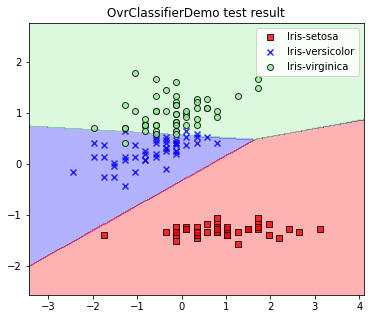

In [5]:
class OvrClassifierDemo(object):
    def __init__(self):
        self.submodels = (model0, model1, model2)
    
    def predict(self, data):
        prob = np.zeros(shape=(data.shape[0], len(self.submodels)))
        res = np.zeros(shape=data.shape[0])
        
        # 각 모델들이 데이터를 양성으로 분류할 확률을 구한 후
        for midx, model in enumerate(self.submodels):
            prob[:, midx] = model.output(data)
        
        # 제일 높은 확률에 해당하는 클래스 레이블을 리턴한다
        # 단, data는 여러 개의 데이터 샘플을 포함하는 이차원 배열로 가정
        for didx in range(data.shape[0]):
            res[didx] = np.where(prob[didx, :] == max(prob[didx, :]))[0][0]
        
        return res
            
        

model = OvrClassifierDemo()

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot()

plot_decision_regions(X_std, y, model, resolution=0.02, names=ynames, ax=ax)

ax.set_title("OvrClassifierDemo test result")
ax.legend(loc="upper right")

plt.show()

위에서 정의한 OvrClassifierDemo는 실제 다중 분류기의 간소화된 버전으로 미리 정의되어있는 모델들을 활용하여 예측하는 형태로 동작한다. 위의 결정 경계 그래프를 통해 실제로 앞서 구현한 여러 개의 이진 분류기 모델들을 이용해 다중 분류기 모델을 구현하는 것이 가능함을 알 수 있다.

이처럼 하나의 클래스 레이블만을 판별하는 여러 개의 이진 분류기 모델들을 OvR(One versus Rest, 일대다) 분류기라고 부른다. 그리고 OvR 분류기들을 여러개 조합하면 다중 클래스 분류기를 구현할 수 있다.

projectfiles 폴더의 ovrclassifier 모듈에 정의되어있는 OVRClassifier이 앞서 구현한 다중 분류기 모델의 한 형태이다. 코드는 파일을 참고하라.